## Face and Facial Keypoint detection

After the network is trained we can then apply this network to any image that includes faces.

1. Detect all the faces in an image using a face detector using a Haar Cascade detector in this notebook
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that the network expects.
3. Use the trained model to detect facial keypoints on the image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

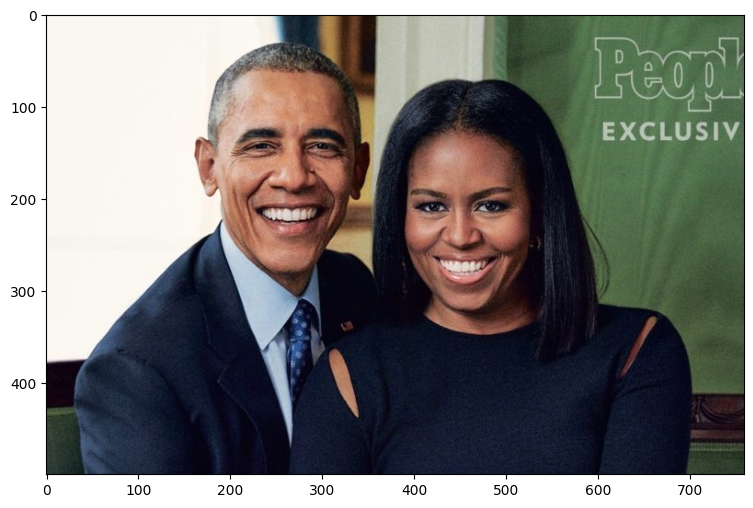

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Using OpenCV's pre-trained Haar Cascade classifiers
In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original).

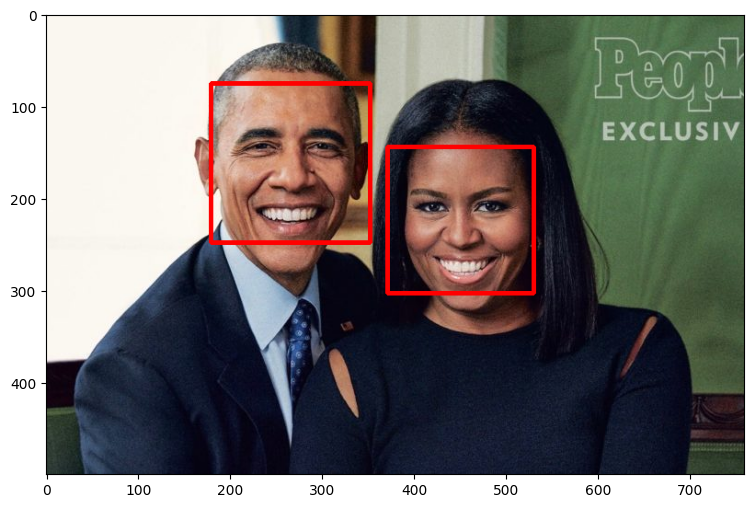

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once we have an image to work with, the next step is to pre-process that image and feed it into the CNN facial keypoint detector.

In [ ]:
import torch
from models import Net

net = Net()

## load the best saved model parameters (by your path name)

net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
#print(net)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

## Keypoint detection

### Transform each detected face into an input Tensor

For each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for the CNN (224x224)
4. Reshape the numpy image into a torch image.

Detect and display the predicted keypoints
The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display



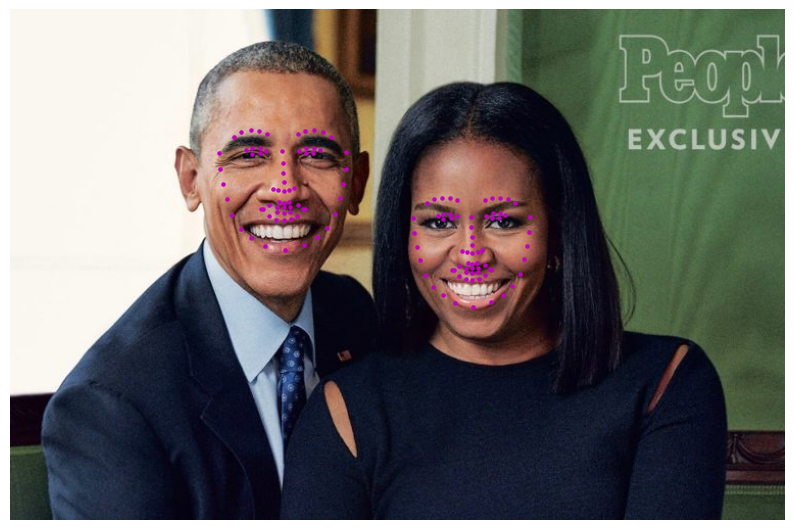

In [ ]:
image_copy = np.copy(image)

plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.imshow(image_copy)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    # Add padding to the ROI
    pad_h = h * 0.25
    pad_w = w * 0.25
    
    y_start = max(0, int(y - pad_h))
    x_start = max(0, int(x - pad_w))
    y_end = min(image.shape[0], int(y + h + pad_h))
    x_end = min(image.shape[1], int(x + w + pad_w))
    
    # Update dimensions after padding
    h_new = y_end - y_start
    w_new = x_end - x_start
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y_start:y_end, x_start:x_end]
    
    ## Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi / 255.0
    
    ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = np.expand_dims(roi, axis=0)  # Add channel dimension: (1, 224, 224)
    roi = np.expand_dims(roi, axis=0)  # Add batch dimension: (1, 1, 224, 224)
    roi = torch.from_numpy(roi).float()
    
    ## Make facial keypoint predictions using your loaded, trained network 
    output_pts = net(roi)
    output_pts = output_pts.view(68, -1)
    output_pts = output_pts.detach().numpy()
    output_pts = output_pts * 50.0 + 100
    
    #Scale keypoints back to the original (padded) ROI size
    output_pts[:, 0] *= (w_new / 224)
    output_pts[:, 1] *= (h_new / 224)
    
    ## Display each detected face and the corresponding keypoints        
    plt.scatter(output_pts[:, 0] + x_start, output_pts[:, 1] + y_start, s=20, marker='.', c='m')

plt.axis('off')
plt.show()